In [144]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [195]:
class Backpack:
    # classe définissant un individu
    max_vol = 30
    
    def __init__(self, chromosome: np.ndarray):
        self.items = np.zeros((len(chromosome),))
        self.chromosome = chromosome.astype(np.bool)
        self.volume = 0
        self.value = 0
        self.score = 0
        
    def __repr__(self):
        return f"""Value: {self.value}, Volume: {self.volume}""" 
    
    def pick_items(self, items):
        self.items = items[self.chromosome]
        self.volume = np.sum(np.array([it.volume for it in self.items]))
        self.value = np.sum(np.array([it.value for it in self.items]))
        self.score = 0 if self.volume > Backpack.max_vol else self.value / (self.volume + 1e-8)
        
        # le score est défini comme le rapport valeur/volume du sac. On définit également un volume limite de 30.
        
    def reproduce_with(self, backpack):
        # reproduction par crossing-over aléatoire
        crossing_over = np.random.randint(1, len(self.chromosome) - 1)
        dna1 = backpack.chromosome[:crossing_over]
        dna2 = self.chromosome[crossing_over:]
        hybrid = np.hstack([dna1, dna2])
        return Backpack(hybrid)
        
    def mutate(self):
        # mutation d'un locus sur le gêne
        locus = np.random.randint(len(self.chromosome))
        self.chromosome[locus] = False if self.chromosome[locus] else True

In [196]:
class Item:
    # classe définissant un objet
    def __init__(self, ID: int, value: int, volume: int):
        self.volume = volume
        self.value = value
        self.id = ID
        
    def __repr__(self):
        return f"""
        Item {self.id}:
        Volume: {self.volume}
        Value: {self.value}"""

In [249]:
class Population:
    # algorithme génétique
    def __init__(self, population: int, mutation_rate: float=0.05, nb_items: int=30, survival_rate: float=0.2):
        self.nb_indiv = population
        self.mutation_rate = mutation_rate
        self.nb_items = nb_items
        self.nb_survivors = math.ceil(self.nb_indiv * survival_rate) # élite selectionnée
        self.items = self.generate_items()
        self.population = self.die_and_give_birth(0)
        self.history = {0: self.population}
        
    def generate_items(self):
        # construction aléatoire d'objets
        rand_volumes = np.random.randint(1, 9, self.nb_items)
        coeff = np.sin(np.random.randn(self.nb_items)) + 3
        coeff = coeff * (coeff > -0.9)
        rand_values = rand_volumes + coeff * rand_volumes # la valeur est définie à l'aide d'un coefficient multiple du volume
        return np.array([Item(i, val, vol) for i, val, vol in zip(range(self.nb_items), rand_values, rand_volumes)])
    
    def die_and_give_birth(self, generation: int):
        population = []
        if generation == 0:
            # premier pool
            packs = []
            for i in range(self.nb_indiv):
                pack = Backpack(np.random.randint(0, 2, self.nb_items, dtype="bool"))
                pack.pick_items(self.items)
                packs.append(pack)
            return np.array(packs)
        else:
            ancestors = self.select() # sélection de l'élite
            new_pop = self.reproduce_and_mutate(ancestors) # reproduction/mutation
            self.history[generation] = new_pop
            return new_pop
    
    def reproduce_and_mutate(self, ancestors):
        babies = []
        # reproduction aléatoire
        while len(babies) < self.nb_indiv:
            np.random.shuffle(ancestors)
            baby = ancestors[0].reproduce_with(ancestors[1])
            babies.append(baby)
        
        babies = np.array(babies)
        
        # mutations
        mutants = np.random.choice([True, False], len(babies), p=[self.mutation_rate, 1-self.mutation_rate])
        for i, b in enumerate(babies):
            if i in mutants:
                b.mutate()
        
        for b in babies:
            b.pick_items(self.items) # attribution du score
        
        return np.array(babies)
    
    def select(self):
        # selection de l'élite des meilleurs scores
        df_pop = pd.DataFrame({"score": [b.score for b in self.population]})
        df_pop = df_pop.sort_values(by="score", ascending=False)
        survivors_idx = df_pop.index[:self.nb_survivors]
        return self.population[survivors_idx]
        
    def evolve(self, epochs):
        for e in tqdm(range(epochs)):
            self.population = self.die_and_give_birth(generation=e+1)
        return self.history

# Score en fonction de l'élite

In [282]:
tests = [
    Population(population=200, 
               survival_rate=0.05),
    Population(population=200, 
               survival_rate=0.1),
    Population(population=200, 
               survival_rate=0.2),
    Population(population=200, 
               survival_rate=0.5),
    Population(population=200, 
               survival_rate=0.7),
    Population(population=200, 
               survival_rate=0.8),
        ]

In [283]:
histories = [p.evolve(100) for p in tests]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.20it/s]


In [286]:
data = []
for h in histories:
    mean = []
    for gen in range(100):
        scores = [b.score for b in h[gen]]
        mean.append(np.mean(scores))
    data.append(mean)

Text(0, 0.5, 'Score (valeur / volume)')

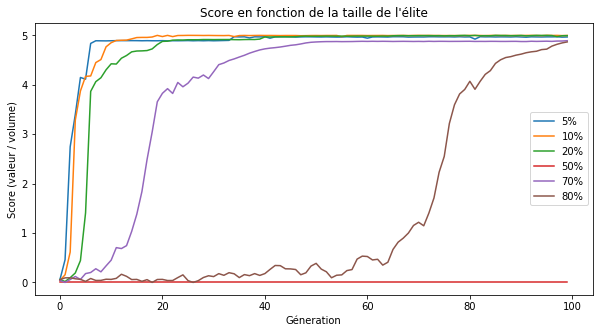

In [299]:
rates = ["5%", "10%", "20%", "50%", "70%", "80%"]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot((111))
ax.set_title("Score en fonction de la taille de l'élite")
for r, d in zip(rates, data):
    ax.plot(d, label=r)
    ax.legend()
ax.set_xlabel("Géneration")
ax.set_ylabel("Score (valeur / volume)")

# Score en fonction du taux de mutation

In [303]:
tests = [
    Population(population=200, 
               mutation_rate=0.05),
    Population(population=200, 
               mutation_rate=0.1),
    Population(population=200, 
               mutation_rate=0.2),
    Population(population=200, 
               mutation_rate=0.5),
    Population(population=200, 
               mutation_rate=0.7),
    Population(population=200, 
               mutation_rate=0.8),
        ]

In [304]:
histories = [p.evolve(100) for p in tests]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.21it/s]


In [305]:
data = []
for h in histories:
    mean = []
    for gen in range(100):
        scores = [b.score for b in h[gen]]
        mean.append(np.mean(scores))
    data.append(mean)

Text(0, 0.5, 'Score (valeur / volume)')

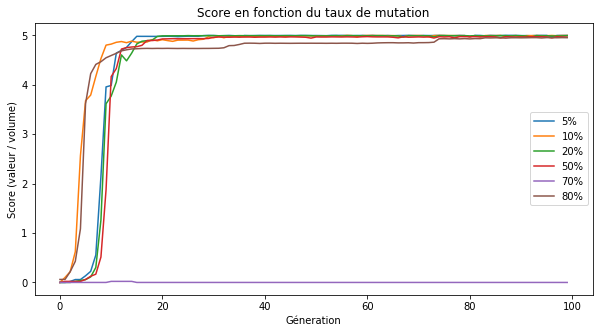

In [307]:
rates = ["5%", "10%", "20%", "50%", "70%", "80%"]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot((111))
ax.set_title("Score en fonction du taux de mutation")
for r, d in zip(rates, data):
    ax.plot(d, label=r)
    ax.legend()
ax.set_xlabel("Géneration")
ax.set_ylabel("Score (valeur / volume)")